# Import Libraries

In [1]:
# !pip install -q -U tensorflow-gpu==2.10.0
# !pip install -q -U tensorflow_hub
# !pip install -q scikeras
# !pip install -q catboost
# !pip install -q opencv-python
# !pip install -q shap
# !pip install -q -U segment_anything
# !pip install -q -U torch
# !pip install -q -U typing_extensions
# !pip install -q -U Cython
# !pip install -q -U sympy
# !pip install -q -U torchvision

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import tensorflow as tf

print(tf.test.is_built_with_cuda())

gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs: ", len(gpus))

# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
#         )
#         if len(gpus) > 1:
#             tf.config.experimental.set_virtual_device_configuration(
#                 gpus[1],
#                 [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
#             )
#     except RuntimeError as e:
#         print(e)

True
Available GPUs:  1


In [4]:
# for load data
# from glob import glob
import os # for file handling
import glob # for file handling
import re # for regular expression
import shutil # for moving files

# scientific computing library
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# for data preprocessing
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
# for image preprocessing
# from keras.preprocessing.image import ImageDataGenerator
# for model building
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.layers import Layer, DepthwiseConv2D, Conv2D, Activation, BatchNormalization, Lambda
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Dense, Input, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import img_to_array, load_img
import tensorflow_hub as hub
from segment_anything import sam_model_registry, SamPredictor



# Set Up

In [5]:
%matplotlib inline

In [6]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
INPUT_SHAPE = (256, 256, 3)
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 50
SEED = 11
keras.utils.set_random_seed(SEED)
AUTO = tf.data.experimental.AUTOTUNE

## Links

In [7]:
data_path = 'G:\\HSUHK\\COM6003\\project\\archive\\'
file_name1 = 'imageIndex6.csv'
file_name2 = 'imageIndex2.csv'
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
checkpoint_path = 'G:\\HSUHK\\COM6003\\project\\archive\\sam_vit_h_4b8939.pth'

## Define Callbacks

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1)

# Function

## Load Data

In [9]:
def load_data(data_path=None, file_name=None, dataframe=None):
    if dataframe is not None:
        df = dataframe
    else:
        df = pd.read_csv(data_path+file_name).drop(columns=['index'])
    x = pd.DataFrame(df['img_id'])
    y = df.drop(columns=['img_id']).iloc[:,0]
    return x, y, df

## Balance Dataset

In [10]:
def balance_dataset(x, y):
    """Balance the dataset"""
    # calculate the number of samples in each class
    class_counts = Counter(y)
    min_class_count = min(class_counts.values())
    # set the sampling strategy for both over and under sampling
    if min_class_count <= 300:
        under_sample_strategy = {label: min_class_count for label in class_counts.keys()}
    else:
        under_sample_strategy = {label: 300 for label in class_counts.keys()}
    # initialize the NearMiss object
    nm = RandomUnderSampler(random_state=SEED, sampling_strategy=under_sample_strategy)
    # fit the object to the training data
    x_resampled, y_resampled = nm.fit_resample(x, y)
    # calculate the class weights
    class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
    class_weights = dict(enumerate(class_weights))

    return x_resampled, y_resampled, class_weights

## Find Selected Images

In [11]:
def find_selected_images(x, source_dir):
    img_ids = set(x.iloc[:,0].values)
    return [file for file in glob.glob(os.path.join(source_dir, '**', '*.png'), recursive=True)
            if os.path.basename(file) in img_ids]

## Copy to Destination

In [12]:
def copy_to_destination(file_paths, dest_dir):
    """Copy files to the destination directory, creating it if it doesn't exist."""
    os.makedirs(dest_dir, exist_ok=True)
    for file_path in file_paths:
        shutil.copy(file_path, dest_dir)

## Redirect Data

In [13]:
def redirect_data(x, source_dir):
    x['img_id'] = source_dir + '\\' + x['img_id']
    return x

## Data Preprocessing

In [14]:
def data_preprocessing(data_path, file_name):
    x, y, df = load_data(data_path, file_name)
    # first to split the data into train, val, and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=SEED)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=SEED)
    # then balance the training data
    x_resampled, y_resampled, class_weights = balance_dataset(x_train, y_train)
    train_path = os.path.join(data_path,f"{file_name[5:11]}\\train")
    val_path = os.path.join(data_path,f"{file_name[5:11]}\\val")
    test_path = os.path.join(data_path,f"{file_name[5:11]}\\test")
    # check if the directories already exist
    if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
        print("Directories already exist.")
        x_resampled = redirect_data(x_resampled, train_path)
        x_val = redirect_data(x_val, val_path)
        x_test = redirect_data(x_test, test_path)
    else:
        # else make directory, copy the images to the respective directories, and redirect the data
        os.makedirs(train_path,exist_ok=True)
        copy_to_destination(find_selected_images(x_resampled, data_path), train_path)
        x_resampled = redirect_data(x_resampled, train_path)
        os.makedirs(val_path,exist_ok=True)
        copy_to_destination(find_selected_images(x_val, data_path), val_path)
        x_val = redirect_data(x_val, val_path)
        os.makedirs(test_path,exist_ok=True)
        copy_to_destination(find_selected_images(x_test, data_path), test_path)
        x_test = redirect_data(x_test, test_path)

    # return the train, val, and test data; besides, the data directory
    return x_resampled, x_val, x_test, y_resampled, y_val, y_test, class_weights, train_path, val_path, test_path


## Image Data Generator

In [15]:
def create_datagen(x_train, y_train, x_val, y_val, x_test, y_test, img_size=(256, 256), batch_size=16, channels=3):
    """ Create data generators for training, validation, and testing datasets. """
    def img_preprocessing(img, label):
        """ Image preprocessing function """
        img = tf.io.read_file(img)  # Read the image file
        img = tf.image.decode_png(img, channels=channels)  # Decode the PNG image
        img = tf.image.resize(img, img_size)  # Resize the image
        img = tf.cast(img, tf.float32) / 255.0  # Normalize pixel values to [0, 1] range
        return img, label

    def augmentation(image, label):
        """ Data augmentation function """
        image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
        image = tf.image.random_flip_up_down(image)  # Randomly flip the image vertically
        image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # Randomly rotate the image
        image = tf.image.random_brightness(image, max_delta=0.2)  # Randomly adjust brightness
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Randomly adjust contrast
        return image, label

    def create_dataset(x, y, augment=False):
    # Create dataset loaders and tf.datasets
        loader = tf.data.Dataset.from_tensor_slices((x.iloc[:,0], y))
        if augment:
            dataset = (loader.map(img_preprocessing, num_parallel_calls=AUTO)  # Apply image preprocessing function)
                            .map(augmentation, num_parallel_calls=AUTO)  # Apply data augmentation function
                            .batch(batch_size)  # Batch the data
                            .shuffle(batch_size * 10)  # Shuffle the dataset
                            .prefetch(AUTO).repeat())  # Prefetch data for performance
        else:
            dataset = (loader.map(img_preprocessing, num_parallel_calls=AUTO)
                            .batch(batch_size) # Batch the data
                            .prefetch(AUTO).repeat()) # Prefetch data for performance
            
        return dataset

    train_dataset = create_dataset(x_train, y_train, augment=True)
    val_dataset = create_dataset(x_val, y_val)
    test_dataset = create_dataset(x_test, y_test)
    

    return train_dataset, val_dataset, test_dataset

# Data Processing for 6 Classes 

In [16]:
x_train, x_val, x_test, y_train, y_val, y_test, class_weights, train_path, val_path, test_path = data_preprocessing(data_path, file_name1)

Directories already exist.


## Classes Set Up

In [17]:
NUM_CLASSES = y_train.nunique()
CLASS_MODE = 'categorical' if NUM_CLASSES > 2 else 'binary'

In [18]:
train_dataset, val_dataset, test_dataset = create_datagen(x_train, y_train, x_val, y_val, x_test, y_test,
                                                        img_size=IMG_SIZE, batch_size=BATCH_SIZE)

In [19]:
def show_images(dataset, class_mode, num_rows=2, num_cols=4):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    # Iterate over the dataset
    for images, labels in dataset:
        # Get the true labels based on the class_mode
        if class_mode == 'categorical':
            true_labels = labels.numpy().squeeze()
        elif class_mode == 'binary':
            true_labels = labels.numpy().flatten()
        else:
            raise ValueError(f"Invalid class_mode: {class_mode}")
        # Iterate over each image and label in the batch
        for i, (image, label) in enumerate(zip(images, true_labels)):
            # Get the corresponding axis
            ax = axes[i]
            # Display the image
            ax.imshow(image.numpy())
            # Set the title of the subplot based on the class_mode
            if class_mode == 'categorical':
                true_label_index = np.argmax(label)
                ax.set_title(f"Label: {true_label_index}")
            elif class_mode == 'binary':
                ax.set_title(f"Label: {label}")
            # Remove the axis ticks
            ax.axis('off')
            # Break the loop after displaying the desired number of images
            if i + 1 == num_rows * num_cols:
                break
        # Adjust the spacing between subplots
        plt.tight_layout()
        # Display the plot
        plt.show()
        # Break the loop after displaying images from one batch
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


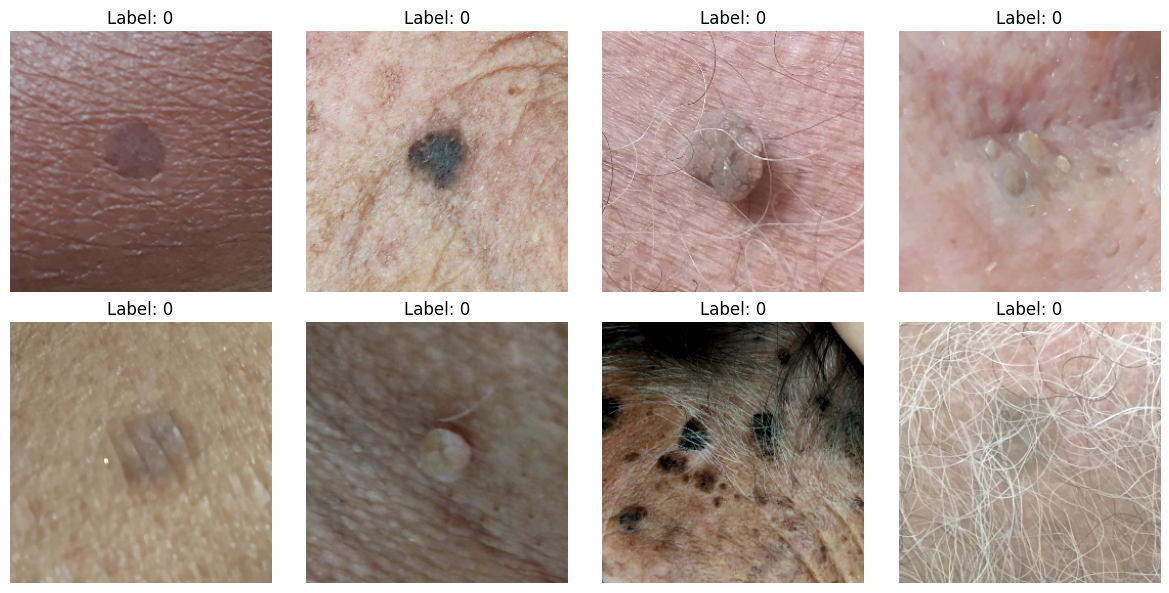

In [20]:
# Call the function with the train_dataset
show_images(train_dataset, class_mode=CLASS_MODE)

After splitting the dataset, which contains 6 classes, into train, val, and test directories, the distribution is as follows: the train directory contains 199 items, the test directory contains 63 items, and the val directory contains 50 items.

# Model for 6 Classes

## ConvMixerModel

### Define the Model

In [21]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        self.deepwise = DepthwiseConv2D(kernel_size=kernel_size, padding='same')
        self.conv1 = Conv2D(filters, kernel_size=1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(self.bn1(X))
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(self.bn2(X))
        print("Shape after block:",X.shape)
        return X

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "kernel_size": self.kernel_size
        }

def ConvMixerModel(img_size, num_classes, num_blocks=2, features=256):
    inp = Input(shape=(*img_size, 3),dtype=tf.float16)
    X = Conv2D(features, 2, 2)(inp)
    X = Activation('gelu')(X)
    X = BatchNormalization()(X)

    for i in range(num_blocks):
        X = ConvMixerBlock(features, 5, name=f'CONVMIXER_{i+1}')(X)

    X = GlobalAveragePooling2D(name='the_last_pooling_layer')(X)
    out = Dense(1 if num_classes == 2 else num_classes, activation='sigmoid' if num_classes == 2 else 'softmax')(X)

    model = Model(inputs=inp, outputs=out)
    return model


### Summary the Model

In [22]:
model1 = ConvMixerModel(IMG_SIZE, NUM_CLASSES)
model1.summary()

Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 256)     3328      
                                                                 
 activation (Activation)     (None, 128, 128, 256)     0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 256)    1024      
 ormalization)                                                   
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 128, 128, 256)    74496     
 )                                                               
                                             

### Compile the Model

In [23]:
optimizer = Adam(learning_rate=1e-4,name='adam_optimizer')

In [24]:
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc', SparseTopKCategoricalAccuracy(k=3, name="top_3_acc")])

### Train the Model

In [25]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [26]:
history1 = model1.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                        callbacks=[early_stopping, learning_rate_reduction])


Epoch 1/50
Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
32/32 [==============================] - ETA: 0s - loss: 1.8568 - acc: 0.1680 - top_3_acc: 0.5240Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
32/32 [==============================] - 15s 267ms/step - loss: 1.8568 - acc: 0.1680 - top_3_acc: 0.5240 - val_loss: 1.7985 - val_acc: 0.1100 - val_top_3_acc: 0.4650 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - 9s 291ms/step - loss: 1.8144 - acc: 0.1800 - top_3_acc: 0.5080 - val_loss: 1.7854 - val_acc: 0.1100 - val_top_3_acc: 0.4600 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - 9s 291ms/step - loss: 1.8086 - acc: 0.1840 - top_3_acc: 0.4880 - val_loss: 1.7692 - val_acc: 0.1100 - val_top_3_acc: 0.7300 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - 9s 292ms/step - loss: 1.7

### Evaluate the Model

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model1.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

 3/28 [==>...........................] - ETA: 1s - loss: 1.7115 - acc: 0.2500 - top_3_acc: 0.7917

28/28 [==============================] - 2s 66ms/step - loss: 1.6995 - acc: 0.2946 - top_3_acc: 0.8259
Test Loss: 1.699480652809143
Test Accuracy: 0.2946428656578064
Test Top 3 Accuracy: 0.8258928656578064


### Plot Training History

In [28]:
def plot_training_history(history):
    """ Plots the training and validation accuracy and loss. """
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Plot for accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
    elif 'acc' in history.history:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()

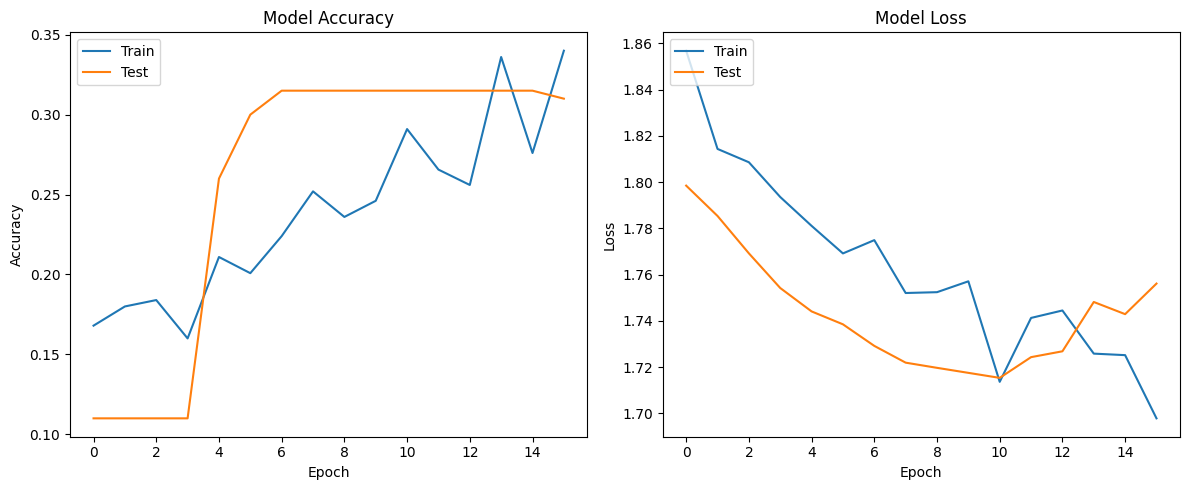

In [29]:
plot_training_history(history1)

## ResNet50

### Define the ResNet50 Model

In [30]:
def resnet50(input_shape, num_classes, base_model_weights='imagenet'):
    """ Create a custom model based on ResNet50 architecture. """
    # Load the ResNet50 model
    base_model = ResNet50(include_top=False, weights=base_model_weights,
                          input_tensor=Input(shape=input_shape),
                          pooling='avg')

    # Add a custom head to the model
    x = base_model.output
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1 if num_classes==2 else num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')(x)

    # Create an instance of the model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [31]:
model2 = resnet50(INPUT_SHAPE, num_classes=NUM_CLASSES)


### Summary the Model

In [32]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Compile the Model

In [33]:
model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['acc', SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)]
)

### Train the Model

In [34]:
history2 = model2.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                      callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50
32/32 [==============================] - 10s 105ms/step - loss: 2.0955 - acc: 0.1320 - top_3_acc: 0.4680 - val_loss: 2.5246 - val_acc: 0.3200 - val_top_3_acc: 0.5400 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - 3s 99ms/step - loss: 1.6898 - acc: 0.3160 - top_3_acc: 0.6440 - val_loss: 3.6120 - val_acc: 0.1000 - val_top_3_acc: 0.5250 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - 3s 101ms/step - loss: 1.5345 - acc: 0.3680 - top_3_acc: 0.7320 - val_loss: 5.0721 - val_acc: 0.1000 - val_top_3_acc: 0.5200 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - 3s 102ms/step - loss: 1.2248 - acc: 0.5920 - top_3_acc: 0.8240 - val_loss: 8.4838 - val_acc: 0.1000 - val_top_3_acc: 0.7300 - lr: 1.0000e-04
Epoch 5/50
32/32 [==============================] - 3s 100ms/step - loss: 0.9973 - acc: 0.7000 - top_3_acc: 0.9440 - val_loss: 4.6239 - val_acc: 0.1000 - val_top_3_acc: 0.7300 - lr: 1.0000e-04
Epoch 6/50
32/32 [=================

### Evaluate the Model

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model2.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

13/28 [============>.................] - ETA: 0s - loss: 2.8471 - acc: 0.2981 - top_3_acc: 0.4135

28/28 [==============================] - 1s 22ms/step - loss: 2.7411 - acc: 0.2946 - top_3_acc: 0.4598
Test Loss: 2.7411410808563232
Test Accuracy: 0.2946428656578064
Test Top 3 Accuracy: 0.4598214328289032


### Plot Training History

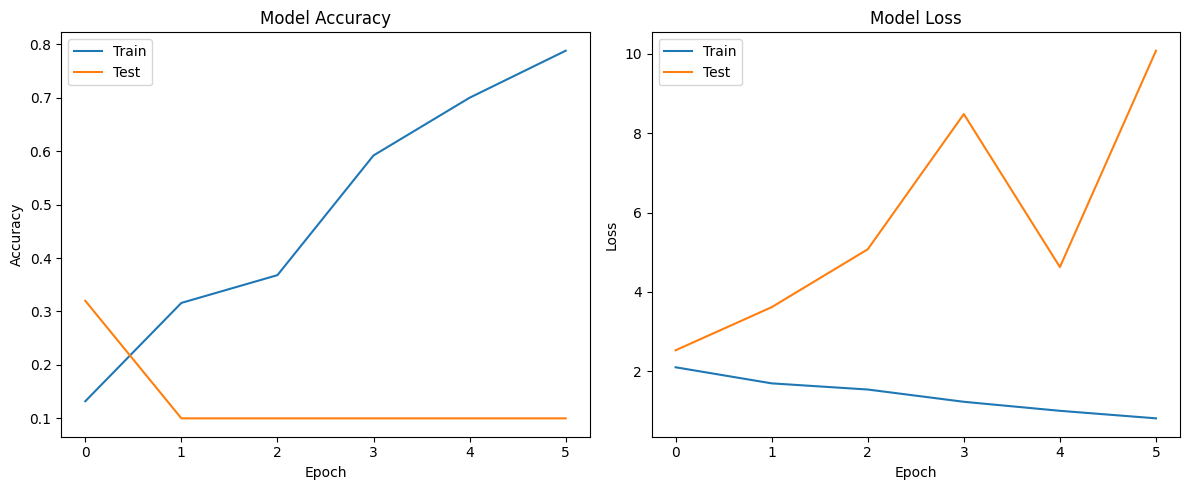

In [36]:
plot_training_history(history2)

## VGG

### Define the VGG Model

In [37]:
def vgg16(input_shape, num_classes):
    """ Create a custom model based on VGG16 architecture. """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1 if num_classes==2 else num_classes))
    model.add(Activation('softmax' if num_classes > 2 else 'sigmoid'))

    return model

In [38]:
model3 = vgg16(INPUT_SHAPE, NUM_CLASSES)

### Summary the Model

In [39]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 activation_3 (Activation)   (None, 252, 252, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 122, 122, 64)      36928     
                                                        

### Compile the Model

In [40]:
model3.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['acc', SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

### Train the Model

In [41]:
history3 = model3.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                      callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50


32/32 [==============================] - 4s 52ms/step - loss: 10.2058 - acc: 0.1200 - top_3_acc: 0.5160 - val_loss: 1.8577 - val_acc: 0.1000 - val_top_3_acc: 0.2450 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 2s 73ms/step - loss: 1.8139 - acc: 0.1240 - top_3_acc: 0.5000 - val_loss: 1.7941 - val_acc: 0.0350 - val_top_3_acc: 0.2700 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 2s 73ms/step - loss: 1.7969 - acc: 0.0977 - top_3_acc: 0.4375 - val_loss: 1.7944 - val_acc: 0.0350 - val_top_3_acc: 0.2450 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 2s 71ms/step - loss: 1.7923 - acc: 0.1721 - top_3_acc: 0.5000 - val_loss: 1.7963 - val_acc: 0.0350 - val_top_3_acc: 0.2700 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 2s 71ms/step - loss: 1.7933 - acc: 0.1280 - top_3_acc: 0.4760 - val_loss: 1.7963 - val_acc: 0.1300 - val_top_3_acc: 0.2750 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 2s 71ms/step - los

### Evaluate the Model

In [42]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model3.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

 8/28 [=======>......................] - ETA: 0s - loss: 1.7920 - acc: 0.0781 - top_3_acc: 0.3125  

28/28 [==============================] - 1s 19ms/step - loss: 1.7894 - acc: 0.0893 - top_3_acc: 0.3080
Test Loss: 1.7894461154937744
Test Accuracy: 0.0892857164144516
Test Top 3 Accuracy: 0.3080357015132904


### Plot Training History

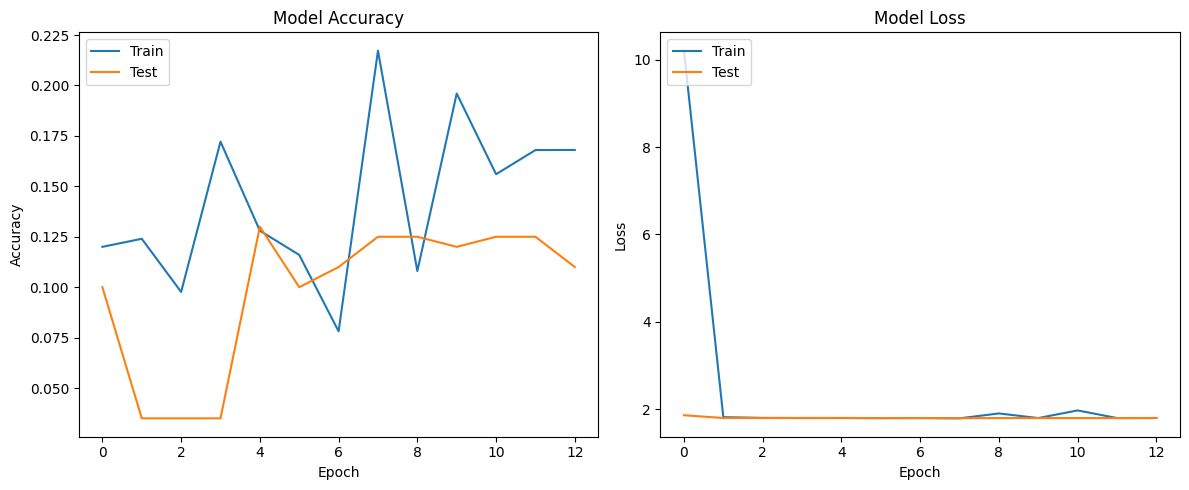

In [43]:
plot_training_history(history3)

## Big Transfer

### Define the BiT Model

In [44]:
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [45]:
# load the model
module = hub.load(bit_model_url)

In [46]:
class MyBiTModel(keras.Model):
    """ Create a custom model based on the BiT model. """
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)

In [47]:
model4 = MyBiTModel(num_classes=NUM_CLASSES, module=module)

### Summary the Model

In [48]:
dummy_input = tf.random.normal(shape=(1, *INPUT_SHAPE))
_ = model4(dummy_input)
model4.summary()

Model: "my_bi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             multiple                  12294     
                                                                 
Total params: 12,294
Trainable params: 12,294
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [49]:
# define the optimizer, loss function
optimizer = SGD(learning_rate=0.01, momentum=0.9)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

In [50]:
model4.compile(optimizer=optimizer, loss=loss_fn, metrics=["acc", SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

### Train the Model

In [51]:
history4 = model4.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                        validation_data=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                        callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50
32/32 [==============================] - 11s 102ms/step - loss: 275.0455 - acc: 0.2600 - top_3_acc: 0.6000 - val_loss: 476.8057 - val_acc: 0.4150 - val_top_3_acc: 0.7600 - lr: 0.0100
Epoch 2/50
32/32 [==============================] - 3s 110ms/step - loss: 420.1399 - acc: 0.3360 - top_3_acc: 0.6640 - val_loss: 575.4660 - val_acc: 0.1900 - val_top_3_acc: 0.7550 - lr: 0.0100
Epoch 3/50
32/32 [==============================] - 3s 110ms/step - loss: 389.9945 - acc: 0.3960 - top_3_acc: 0.7600 - val_loss: 784.8766 - val_acc: 0.1550 - val_top_3_acc: 0.3300 - lr: 0.0100
Epoch 4/50
32/32 [==============================] - 3s 110ms/step - loss: 307.3066 - acc: 0.4880 - top_3_acc: 0.7800 - val_loss: 359.6837 - val_acc: 0.3550 - val_top_3_acc: 0.6600 - lr: 0.0100
Epoch 5/50
32/32 [==============================] - 3s 110ms/step - loss: 199.7383 - acc: 0.5280 - top_3_acc: 0.8240 - val_loss: 422.4691 - val_acc: 0.2300 - val_top_3_acc: 0.6600 - lr: 0.0100
Epoch 6/50
32/32 [================

### Evaluate the Model

In [52]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model4.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

 4/28 [===>..........................] - ETA: 1s - loss: 157.0696 - acc: 0.5625 - top_3_acc: 0.9375

28/28 [==============================] - 1s 46ms/step - loss: 129.4780 - acc: 0.6161 - top_3_acc: 0.9196
Test Loss: 129.47802734375
Test Accuracy: 0.6160714030265808
Test Top 3 Accuracy: 0.9196428656578064


### Plot Training History

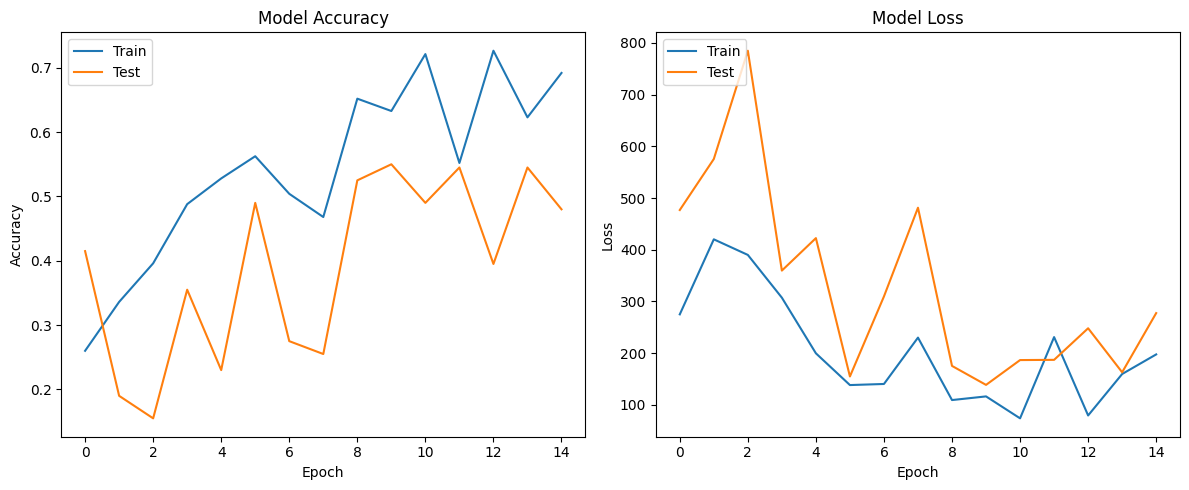

In [53]:
plot_training_history(history4)

## SAM(Segment Anything Model)

In [54]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

### Define the SAM Model

In [55]:
class SAMClassifier:
    def __init__(self, checkpoint_path: str, num_classes: int):
        self.num_classes = num_classes
        self.model = sam_model_registry["vit_h"](checkpoint=checkpoint_path)
        self.predictor = SamPredictor(self.model)
        self.classifier = self._build_classifier()

    def _build_classifier(self):
        inputs = Input(shape=(256, 256, 3))
        x = GlobalAveragePooling2D()(inputs)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(1 if self.num_classes==2 else self.num_classes, activation='sigmoid' if self.num_classes==2 else 'softmax')(x)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def preprocess_image(self, image_path: str) -> np.ndarray:
        image = load_img(image_path, target_size=(1024, 1024))
        image = img_to_array(image)
        image = preprocess_input(image)
        return image

    def extract_features(self, image: np.ndarray) -> np.ndarray:
        self.predictor.set_image(image)
        image_embedding = self.predictor.get_image_embedding()
        return image_embedding

    def predict(self, image_path: str) -> int:
        image = self.preprocess_image(image_path)
        features = self.extract_features(image)
        features = np.expand_dims(features, axis=0)
        predictions = self.classifier.predict(features)
        predicted_class = np.argmax(predictions, axis=1)[0]
        return predicted_class

    def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], **kwargs):
        if self.num_classes == 2:
            loss = 'binary_crossentropy'
        self.classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)

    def fit(self, train_dataset, val_dataset, epochs: int, callbacks, steps_per_epoch=None, validation_steps=None):
        history = self.classifier.fit(
            train_dataset,
            epochs=epochs,
            validation_data=val_dataset,
            callbacks=callbacks,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps
        )
        return history

    def evaluate(self, test_dataset, steps=None):
        loss, accuracy,  test_top_3_accuracy = self.classifier.evaluate(test_dataset, steps=steps)
        return loss, accuracy, test_top_3_accuracy

In [56]:
model5 = SAMClassifier(checkpoint_path, NUM_CLASSES)

### Summary the Model

In [57]:
model5.classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 global_average_pooling2d (G  (None, 3)                0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               2048      
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 5,126
Trainable params: 5,126
Non-trainable params: 0
_________________________________________________________

### Compile the Model

In [58]:
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc', SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

### Train the Model

In [59]:
history5 = model5.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      val_dataset=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                        callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50
32/32 [==============================] - 3s 31ms/step - loss: 1.8229 - acc: 0.1120 - top_3_acc: 0.4280 - val_loss: 1.7704 - val_acc: 0.3150 - val_top_3_acc: 0.4750 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 2s 60ms/step - loss: 1.8273 - acc: 0.0680 - top_3_acc: 0.3400 - val_loss: 1.7999 - val_acc: 0.1200 - val_top_3_acc: 0.3750 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 2s 58ms/step - loss: 1.8094 - acc: 0.1400 - top_3_acc: 0.4160 - val_loss: 1.7843 - val_acc: 0.1250 - val_top_3_acc: 0.5650 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 2s 63ms/step - loss: 1.8090 - acc: 0.1120 - top_3_acc: 0.4240 - val_loss: 1.7806 - val_acc: 0.1250 - val_top_3_acc: 0.5400 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 2s 56ms/step - loss: 1.7940 - acc: 0.1720 - top_3_acc: 0.5080 - val_loss: 1.7700 - val_acc: 0.1250 - val_top_3_acc: 0.7550 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 2s 57ms/

### Evaluate the Model

In [60]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model5.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

12/28 [===========>..................] - ETA: 0s - loss: 1.7862 - acc: 0.0729 - top_3_acc: 0.7604

28/28 [==============================] - 1s 20ms/step - loss: 1.7785 - acc: 0.0893 - top_3_acc: 0.7768
Test Loss: 1.7784597873687744
Test Accuracy: 0.0892857164144516
Test Top 3 Accuracy: 0.7767857313156128


### Plot Training History

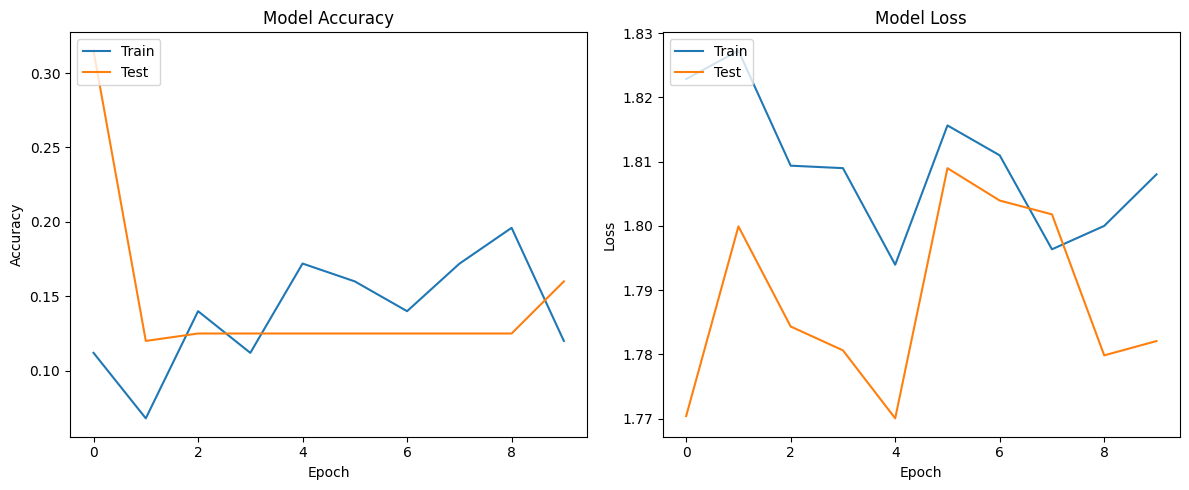

In [61]:
plot_training_history(history5)

## Stacking

# Data Processing for 2 Classes

In [62]:
x_train, x_val, x_test, y_train, y_val, y_test, class_weights, train_path, val_path, test_path = data_preprocessing(data_path, 'imageIndex2.csv')

Directories already exist.


In [63]:
train_dataset, val_dataset, test_dataset = create_datagen(x_train, y_train, x_val, y_val, x_test, y_test, img_size=IMG_SIZE, batch_size=BATCH_SIZE)

In [64]:
NUM_CLASSES = y_train.nunique()
CLASS_MODE = 'categorical' if NUM_CLASSES > 2 else 'binary'

# Model for 2 Classes

## ConvMixerModel

### Summary the Model

In [65]:
model6 = ConvMixerModel(IMG_SIZE, NUM_CLASSES)
model6.summary()

Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 256)     3328      
                                                                 
 activation_8 (Activation)   (None, 128, 128, 256)     0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 256)    1024      
 hNormalization)                                                 
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 128, 128, 256)    74496     
 )                                                               
                                           

### Compile the Model

In [66]:
optimizer = Adam(learning_rate=1e-4,name='adam_optimizer')

In [67]:
model6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc', SparseTopKCategoricalAccuracy(k=3, name="top_3_acc")])

### Train the Model

In [68]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [69]:
history6 = model6.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                        callbacks=[early_stopping, learning_rate_reduction])


Epoch 1/50
Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)


Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
75/75 [==============================] - ETA: 0s - loss: 0.7129 - acc: 0.4950 - top_3_acc: 0.5000Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
75/75 [==============================] - 26s 282ms/step - loss: 0.7129 - acc: 0.4950 - top_3_acc: 0.5000 - val_loss: 0.7017 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 1.0000e-04
Epoch 2/50
75/75 [==============================] - 25s 281ms/step - loss: 0.6983 - acc: 0.5200 - top_3_acc: 0.5000 - val_loss: 0.7101 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 1.0000e-04
Epoch 3/50
75/75 [==============================] - 25s 280ms/step - loss: 0.6975 - acc: 0.4750 - top_3_acc: 0.5000 - val_loss: 0.7086 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 1.0000e-04
Epoch 4/50
75/75 [==============================] - 24s 279ms/step - loss: 0.6922 - acc: 0.5167 - top_3_acc: 0.5000 - val_loss: 0.7093 - val_acc: 0.4500 - val_top_3_acc

### Evaluate the Model

In [70]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model6.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

 3/28 [==>...........................] - ETA: 2s - loss: 0.6898 - acc: 0.5833 - top_3_acc: 0.5833

28/28 [==============================] - 2s 81ms/step - loss: 0.6917 - acc: 0.5000 - top_3_acc: 0.5223
Test Loss: 0.6916678547859192
Test Accuracy: 0.5
Test Top 3 Accuracy: 0.5223214030265808


### Plot Training History

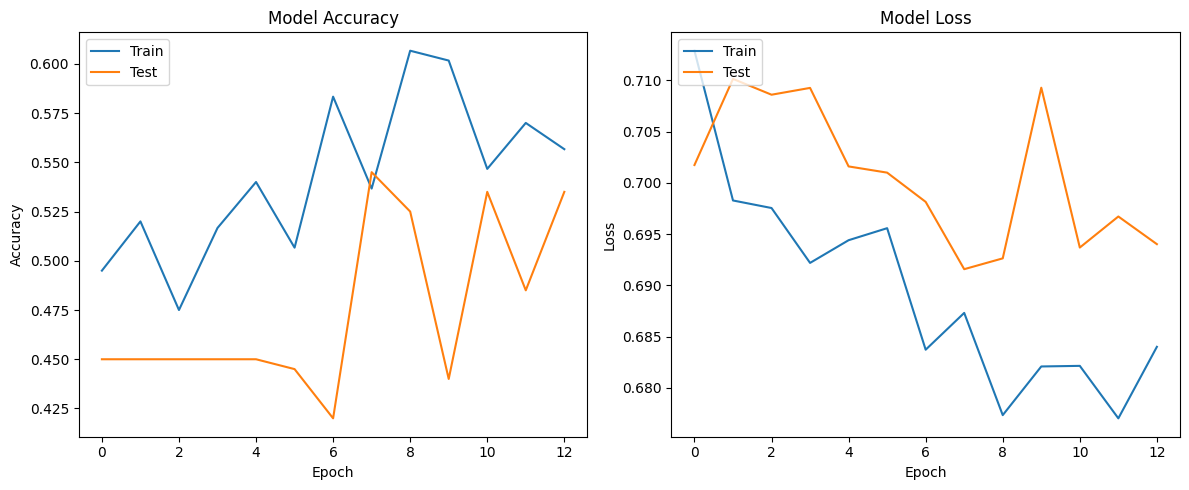

In [71]:
plot_training_history(history6)

## ResNet50

### Define the ResNet50 Model

In [72]:
model7 = resnet50(INPUT_SHAPE, num_classes=NUM_CLASSES)

### Summary the Model

In [73]:
model7.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Compile the Model

In [74]:
model7.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['acc', SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)]
)

### Train the Model

In [75]:
history7 = model7.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                      callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50
75/75 [==============================] - 14s 66ms/step - loss: 0.7234 - acc: 0.5800 - top_3_acc: 0.5000 - val_loss: 1.8628 - val_acc: 0.5500 - val_top_3_acc: 0.5500 - lr: 1.0000e-04
Epoch 2/50
75/75 [==============================] - 8s 60ms/step - loss: 0.6576 - acc: 0.6267 - top_3_acc: 0.5000 - val_loss: 1.2337 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 1.0000e-04
Epoch 3/50
75/75 [==============================] - 7s 58ms/step - loss: 0.5835 - acc: 0.6817 - top_3_acc: 0.5000 - val_loss: 0.7865 - val_acc: 0.5500 - val_top_3_acc: 0.5500 - lr: 1.0000e-04
Epoch 4/50
75/75 [==============================] - 8s 58ms/step - loss: 0.3856 - acc: 0.8633 - top_3_acc: 0.5000 - val_loss: 1.7043 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 1.0000e-04
Epoch 5/50
75/75 [==============================] - 7s 58ms/step - loss: 0.3631 - acc: 0.8600 - top_3_acc: 0.5000 - val_loss: 5.0302 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 1.0000e-04
Epoch 6/50
75/75 [=====================

### Evaluate the Model

In [76]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model7.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

10/28 [=========>....................] - ETA: 0s - loss: 0.6965 - acc: 0.4625 - top_3_acc: 0.5375

28/28 [==============================] - 1s 24ms/step - loss: 0.6890 - acc: 0.5000 - top_3_acc: 0.5223
Test Loss: 0.6889997124671936
Test Accuracy: 0.5
Test Top 3 Accuracy: 0.5223214030265808


### Plot Training History

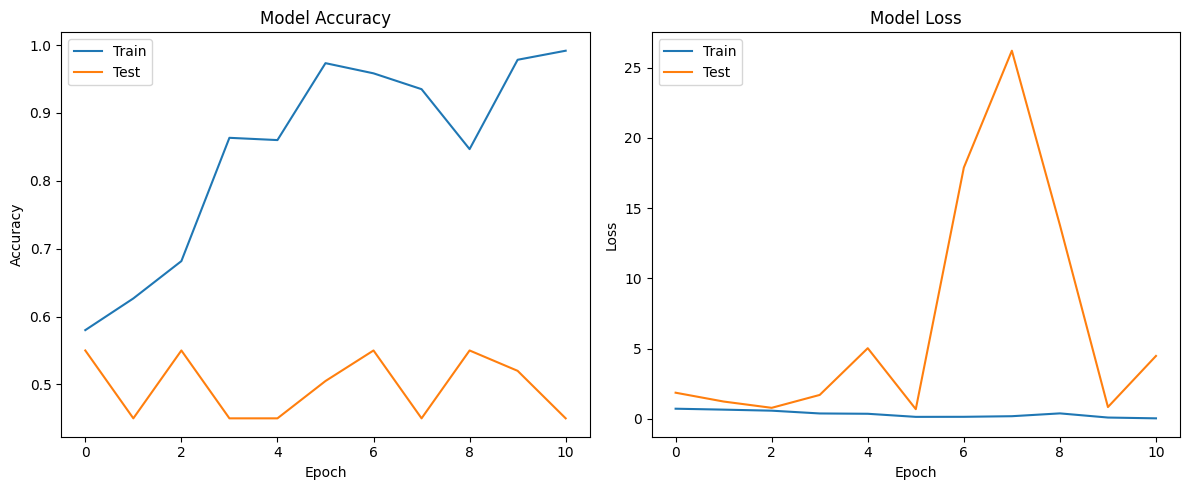

In [77]:
plot_training_history(history7)

## VGG

In [78]:
model8 = vgg16(INPUT_SHAPE, NUM_CLASSES)

### Summary the Model

In [79]:
model8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 252, 252, 32)      9248      
                                                                 
 activation_11 (Activation)  (None, 252, 252, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 124, 124, 64)      18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 122, 122, 64)      36928     
                                                      

### Compile the Model

In [80]:
model8.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

### Train the Model

In [81]:
history8 = model8.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                      callbacks=[early_stopping, learning_rate_reduction],
                      class_weight=class_weights)

Epoch 1/50


75/75 [==============================] - 6s 40ms/step - loss: 220.6349 - acc: 0.5300 - top_3_acc: 0.5000 - val_loss: 0.6968 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 4s 33ms/step - loss: 0.8262 - acc: 0.4550 - top_3_acc: 0.5000 - val_loss: 0.6936 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 5s 34ms/step - loss: 0.6953 - acc: 0.4867 - top_3_acc: 0.5000 - val_loss: 0.6938 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 5s 33ms/step - loss: 0.6947 - acc: 0.5000 - top_3_acc: 0.5000 - val_loss: 0.6941 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 5s 33ms/step - loss: 0.6943 - acc: 0.5000 - top_3_acc: 0.5000 - val_loss: 0.6943 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 5s 33ms/step - lo

### Evaluate the Model

In [82]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model8.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

10/28 [=========>....................] - ETA: 0s - loss: 0.6936 - acc: 0.4625 - top_3_acc: 0.5375

28/28 [==============================] - 1s 27ms/step - loss: 0.6935 - acc: 0.4777 - top_3_acc: 0.5223
Test Loss: 0.6934814453125
Test Accuracy: 0.4776785671710968
Test Top 3 Accuracy: 0.5223214030265808


### Plot Training History

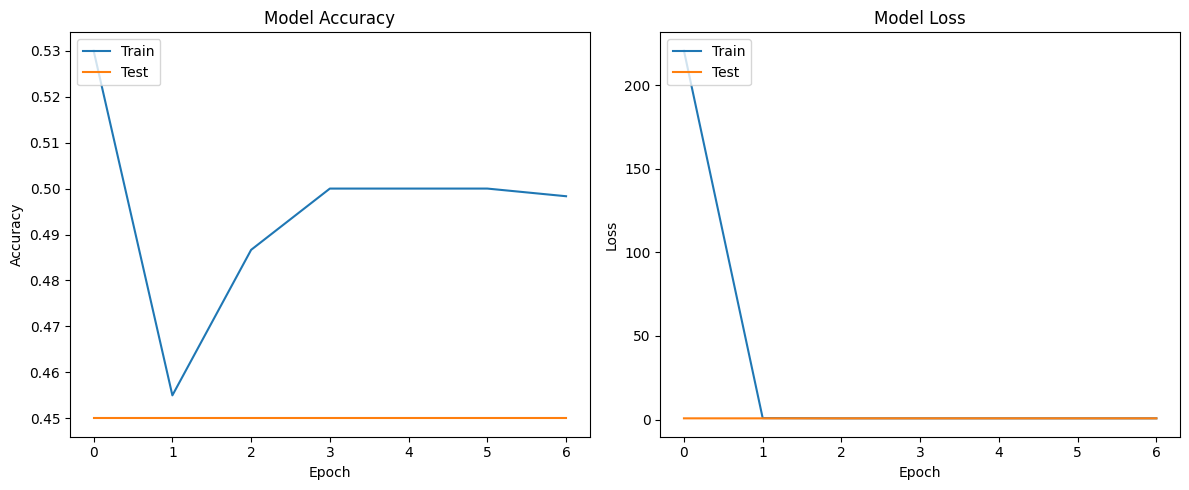

In [83]:
plot_training_history(history8)

## Big Transfer

In [84]:
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [85]:
model9 = MyBiTModel(num_classes=NUM_CLASSES, module=module)

### Summary the Model

In [86]:
dummy_input = tf.random.normal(shape=(1, *INPUT_SHAPE))
_ = model9(dummy_input)
model9.summary()

Model: "my_bi_t_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            multiple                  4098      
                                                                 
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [87]:
# define the optimizer, loss function
optimizer = SGD(learning_rate=0.01, momentum=0.9)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

In [88]:
model9.compile(optimizer=optimizer, loss=loss_fn, metrics=["acc", SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

### Train the Model

In [89]:
history9 = model9.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                        validation_data=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                        callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50
75/75 [==============================] - 10s 66ms/step - loss: 157.6034 - acc: 0.5333 - top_3_acc: 1.0000 - val_loss: 126.8150 - val_acc: 0.6050 - val_top_3_acc: 1.0000 - lr: 0.0100
Epoch 2/50
75/75 [==============================] - 8s 65ms/step - loss: 139.3690 - acc: 0.6983 - top_3_acc: 1.0000 - val_loss: 81.8634 - val_acc: 0.7650 - val_top_3_acc: 1.0000 - lr: 0.0100
Epoch 3/50
75/75 [==============================] - 8s 62ms/step - loss: 202.5872 - acc: 0.6433 - top_3_acc: 1.0000 - val_loss: 253.5745 - val_acc: 0.6200 - val_top_3_acc: 1.0000 - lr: 0.0100
Epoch 4/50
75/75 [==============================] - 8s 60ms/step - loss: 97.1774 - acc: 0.7433 - top_3_acc: 1.0000 - val_loss: 140.2986 - val_acc: 0.6300 - val_top_3_acc: 1.0000 - lr: 0.0100
Epoch 5/50
75/75 [==============================] - 8s 61ms/step - loss: 154.5368 - acc: 0.6967 - top_3_acc: 1.0000 - val_loss: 257.6380 - val_acc: 0.5450 - val_top_3_acc: 1.0000 - lr: 0.0100
Epoch 6/50
75/75 [=======================

### Evaluate the Model

In [90]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model9.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

 3/28 [==>...........................] - ETA: 1s - loss: 19.1542 - acc: 0.8333 - top_3_acc: 1.0000

28/28 [==============================] - 1s 46ms/step - loss: 58.6029 - acc: 0.7857 - top_3_acc: 1.0000
Test Loss: 58.602874755859375
Test Accuracy: 0.7857142686843872
Test Top 3 Accuracy: 1.0


### Plot Training History

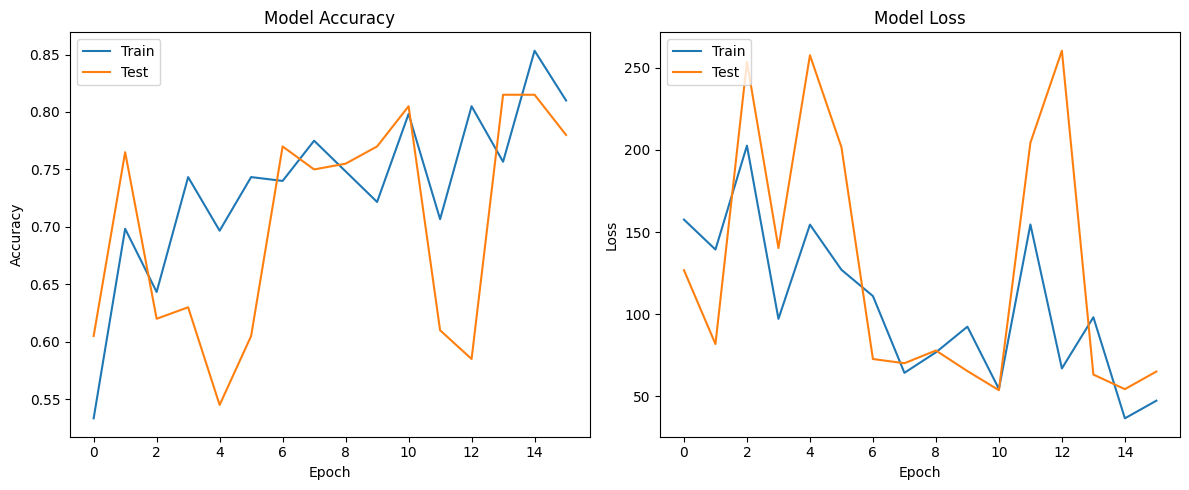

In [91]:
plot_training_history(history9)

## SAM(Segment Anything Model)

### Define the SAM Model

In [92]:
model10 = SAMClassifier(checkpoint_path, NUM_CLASSES)

### Summary the Model

In [93]:
model10.classifier.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 global_average_pooling2d_1   (None, 3)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 512)               2048      
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 513       
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________

### Compile the Model

In [94]:
model10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

### Train the Model

In [95]:
history10 = model10.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                        val_dataset=val_dataset, validation_steps=len(y_val)//BATCH_SIZE,
                        callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50
75/75 [==============================] - 8s 21ms/step - loss: 0.7027 - acc: 0.5050 - top_3_acc: 0.5000 - val_loss: 0.6913 - val_acc: 0.5500 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 5s 17ms/step - loss: 0.6982 - acc: 0.4983 - top_3_acc: 0.5000 - val_loss: 0.6961 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 4s 14ms/step - loss: 0.6998 - acc: 0.5017 - top_3_acc: 0.5000 - val_loss: 0.6895 - val_acc: 0.5500 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 4s 14ms/step - loss: 0.7003 - acc: 0.5000 - top_3_acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.4550 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 4s 14ms/step - loss: 0.7003 - acc: 0.4667 - top_3_acc: 0.5000 - val_loss: 0.6941 - val_acc: 0.4500 - val_top_3_acc: 0.5500 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 4s 14ms/

### Evaluate the Model

In [96]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_top_3_accuracy = model10.evaluate(test_dataset, steps=len(y_test)//BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 3 Accuracy: {test_top_3_accuracy}")

11/28 [==========>...................] - ETA: 0s - loss: 0.6912 - acc: 0.5341 - top_3_acc: 0.5341

28/28 [==============================] - 1s 19ms/step - loss: 0.6920 - acc: 0.5223 - top_3_acc: 0.5223
Test Loss: 0.6919726133346558
Test Accuracy: 0.5223214030265808
Test Top 3 Accuracy: 0.5223214030265808


### Plot Training History

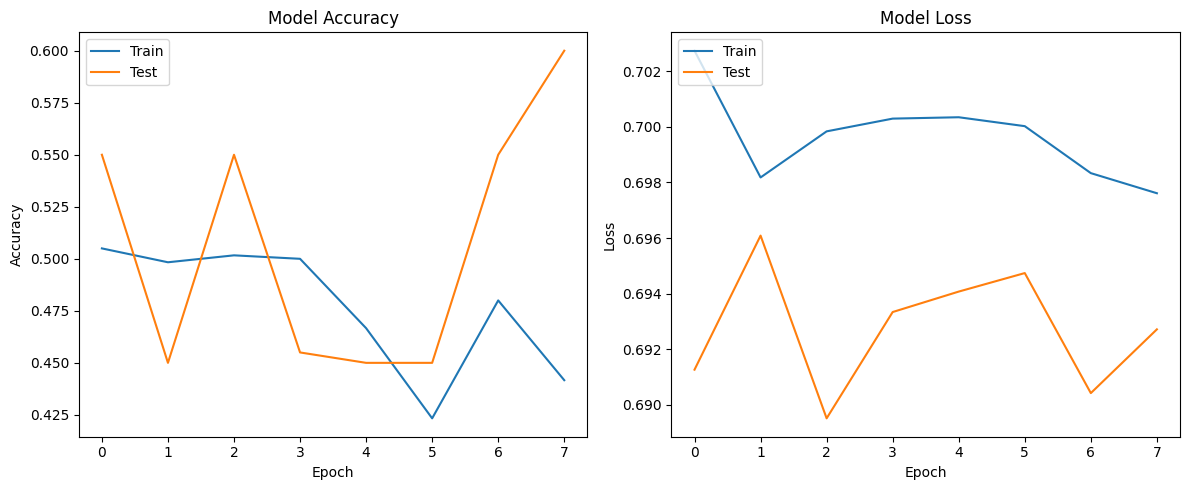

In [97]:
plot_training_history(history10)